In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert
from antropy import sample_entropy
import seaborn as sns


In [38]:
df = pd.read_csv("C:/Analiza Faza Sna/S002_PSG_df_updated.csv")

signal = df['F4-M1'].values

fs = 100 
epoch_length = 30  
samples_per_epoch = fs * epoch_length 

num_epochs = len(signal) // samples_per_epoch
epohe = np.array_split(signal[:num_epochs * samples_per_epoch], num_epochs)
normalized_epochs = []
for epoch in epohe:
    mean = np.mean(epoch)
    std = np.std(epoch)
    if std != 0:
        norm_epoch = (epoch - mean) / std
    else:
        norm_epoch = epoch - mean
    normalized_epochs.append(norm_epoch)

In [28]:
epohe[0].size

3000

In [29]:
bandovi = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}

def bandpower(sig, fs, band):  #filtrira signale po frekvencijama
    low, high = band
    b, a = butter(4, [low / (fs / 2), high / (fs / 2)], btype='band')
    filtered = filtfilt(b, a, sig)
    power = np.sum(filtered ** 2) / len(filtered)
    return power 

In [30]:
def compute_esis(epoch, fs):
    
    energy = np.square(epoch)
    slope = np.abs(np.diff(epoch, prepend=epoch[0]))
    v = fs * slope
    esis = np.sum(energy * v)

    return esis

In [43]:
epohe_features = []

for epoha in normalized_epochs:
    # RACUNANJE FEATUREA
    rms = np.sqrt(np.mean(np.square(epoha))) #ROOT MEAN SQUARE
    mse = np.mean((epoha - np.mean(epoha)) ** 2) #MEAN SQUARED ERROR
    mmd = np.mean(np.abs(np.diff(epoha))) #MINIMAL MAXIMAL DISTANCE
    zcr = ((epoha[:-1] * epoha[1:]) < 0).sum() #ZERO CROSSING RATE
    se = sample_entropy(epoha) #SAMPLE ENTROPY
    esis = compute_esis(epoha, fs)

    talasi = {ime: bandpower(epoha, fs, opseg) for ime, opseg in bandovi.items()}

    red = {
        "RMS": rms,
        "MSE": mse,
        "MMD": mmd,
        "ZCR": zcr,
        "Sample Entropy": se,
        "Esis": esis,
        "Delta": talasi["delta"],
        "Theta": talasi["theta"],
        "Alpha": talasi["alpha"],
        "Beta": talasi["beta"],
        "Gamma": talasi["gamma"]
    }

    epohe_features.append(red)


In [40]:
epohe_features[0:3]

[{'RMS': 1.0,
  'MSE': 1.0,
  'MMD': 0.17974857288618637,
  'ZCR': 224,
  'Sample Entropy': 0.8002773336676623,
  'Esis': 55876.1127697859},
 {'RMS': 0.9999999999999998,
  'MSE': 0.9999999999999997,
  'MMD': 0.2047540957559943,
  'ZCR': 261,
  'Sample Entropy': 0.82666975832732,
  'Esis': 60797.0999620334},
 {'RMS': 1.0,
  'MSE': 1.0000000000000002,
  'MMD': 0.21963441077396345,
  'ZCR': 257,
  'Sample Entropy': 0.7990933426073286,
  'Esis': 66516.5613129954}]

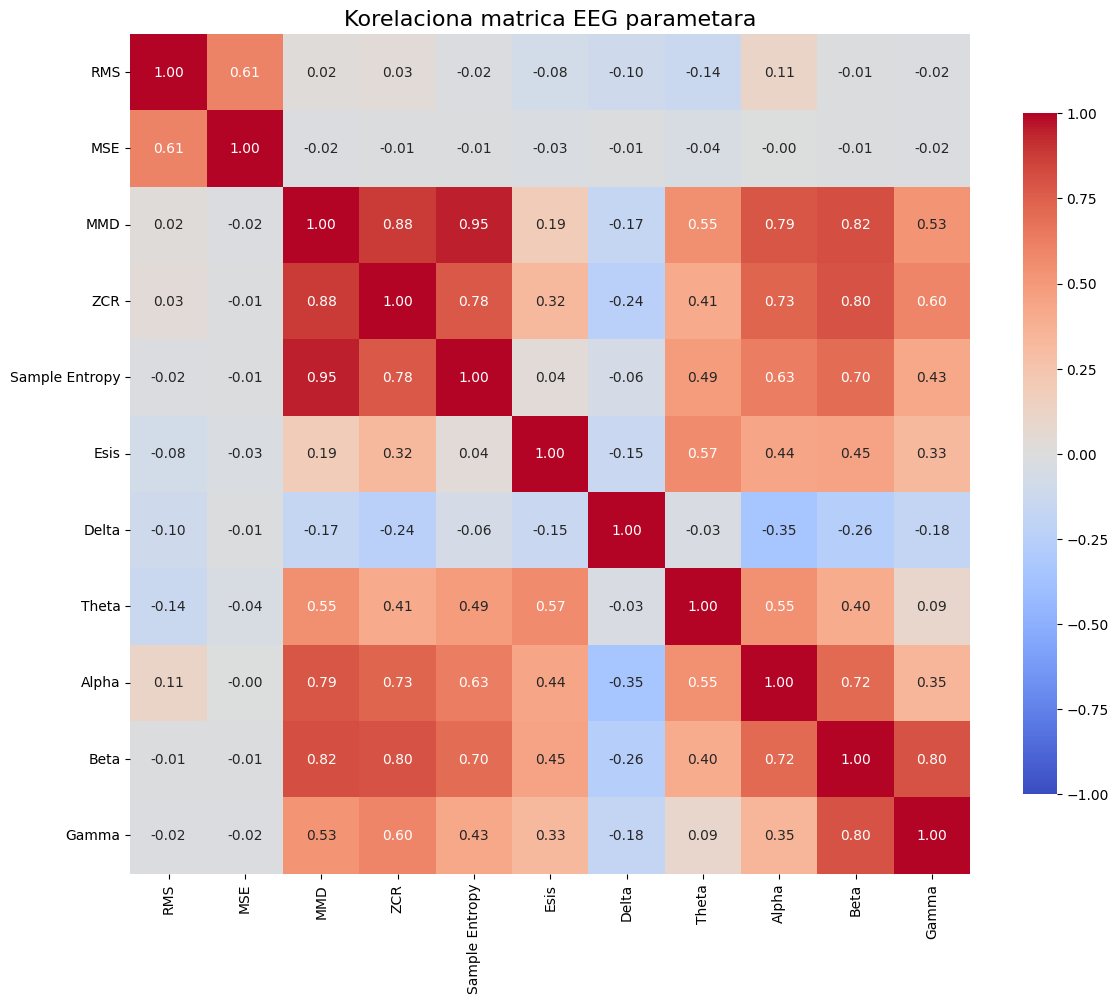

In [44]:

data_za_korelaciju = pd.DataFrame(epohe_features)
# Create the correlation matrix
corr_matrix = data_za_korelaciju.corr()

# Set up the plot
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True,       # show correlation values
            fmt=".2f",         # decimal format
            cmap="coolwarm",   # color scheme
            vmin=-1, vmax=1,   # range of correlation values
            square=True,
            cbar_kws={"shrink": 0.8})

plt.title("Korelaciona matrica EEG parametara", fontsize=16)
plt.tight_layout()
plt.show()

In [45]:

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.8 :
            print(f"{col1} i {col2}: {corr_value:.2f}")

MMD i ZCR: 0.88
MMD i Sample Entropy: 0.95
MMD i Beta: 0.82
Beta i Gamma: 0.80
